In [1]:
%pwd

'/Users/ryandevera/data-science/umn_environments/Deeplifting/deeplifting/notebooks'

In [2]:
%cd ../..

/Users/ryandevera/data-science/umn_environments/Deeplifting


In [3]:
%ls

README.md                       jobs/
__pycache__/                    low-dimension-search-results/
algorithm_compare_results/      models/
data-queue/                     paper-images/
data-queue-2023-09-24/          requirements.txt
deeplifting/                    results/
deeplifting.png                 search_results/
high-dimension-paper-results/   tasks.py
high-dimension-search-results/  test-low-dimension-results.png
images/


In [4]:
import glob as glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm

# High Dimensional Deeplifting Results

The final data will be in the `data-queue/high-dimensional-deeplifting`. We will need to continue to extract the information from MSI.

In [5]:
columns = [
    'f',
    'algorithm',
    'total_time',
    'input_size',
    'hidden_size',
    'hidden_activation',
    'output_activation',
    'agg_function',
    'include_bn',
    'problem_name',
    'global_minimum',
    'dimensions',
]

# Bring in the deeplifting results
dl_file_directory = './data-queue-2023-09-24/high-dimension-deeplifting/*/*'
dl_files = glob.glob(dl_file_directory)

deeplifting_data_list = []
for file in tqdm.tqdm(dl_files):
    df = pd.read_parquet(file)
    df = df[columns]
    df['hits'] = np.abs(df['f'] - df['global_minimum']) <= 1e-5
    deeplifting_data_list.append(df)

deeplifting_df = pd.concat(deeplifting_data_list)
del deeplifting_data_list

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1859/1859 [00:25<00:00, 74.24it/s]


In [6]:
deeplifting_df.head()

,f,algorithm,total_time,input_size,hidden_size,hidden_activation,output_activation,agg_function,include_bn,problem_name,global_minimum,dimensions,hits
0,9.607615e-08,Deeplifting,9.858513,1,512-512,sine,dual_relu,sum,True,alpine1_5d,0.0,5,True
1,2.955329e-07,Deeplifting,4.208653,1,512-512,sine,dual_relu,sum,True,alpine1_5d,0.0,5,True
2,8.137171e-08,Deeplifting,6.354837,1,512-512,sine,dual_relu,sum,True,alpine1_5d,0.0,5,True
3,2.225452e-07,Deeplifting,6.095446,1,512-512,sine,dual_relu,sum,True,alpine1_5d,0.0,5,True
4,1.341622e-06,Deeplifting,5.907741,1,512-512,sine,dual_relu,sum,True,alpine1_5d,0.0,5,True


In [7]:
test_df = deeplifting_df.groupby(
    [
        'algorithm',
        'problem_name',
        'dimensions',
        'input_size',
        'hidden_size',
        'hidden_activation',
        'output_activation',
        'agg_function',
        'include_bn',
    ]
).agg({'hits': ['count', 'mean'], 'total_time': 'mean'})

test_df.columns = ['-'.join(column) for column in test_df.columns]

test_df = test_df.reset_index()
test_df = test_df.sort_values(
    ['problem_name', 'hits-mean', 'total_time-mean'],
    ascending=[True, False, True],
)
test_df = test_df.reset_index(drop=True)
test_df = test_df.groupby(['problem_name']).first().reset_index()
test_df = test_df.rename(columns={'total_time-mean': 'time-mean'})

# Final deeplifting columns
columns = ['problem_name', 'algorithm', 'dimensions', 'hits-mean', 'time-mean']
test_df = test_df[columns]
test_df.head()

,problem_name,algorithm,dimensions,hits-mean,time-mean
0,ackley_1000d,Deeplifting,1000,0.8,56.463580
1,ackley_100d,Deeplifting,100,1.0,0.950878
2,ackley_30d,Deeplifting,30,0.9,2.321085
3,ackley_3d,Deeplifting,3,0.7,1.329230
4,ackley_500d,Deeplifting,500,1.0,1.007298


In [8]:
# # We need to get the results over all of the different configuration
# # and we will report on the best results
# groupby_columns = [
#     'algorithm',
#     'problem_name',
#     'dimensions',
#     'input_size',
#     'hidden_activation',
#     'output_activation',
#     'agg_function',
#     'include_bn',
# ]

# # Final deeplifting columns
# columns = ['problem_name', 'algorithm', 'dimensions', 'hits-mean', 'total_time-mean']

# deeplifting_results_df = deeplifting_df.groupby(groupby_columns).agg(
#     {'hits': ['count', 'mean'], 'total_time': 'mean'}
# )
# deeplifting_results_df.columns = [
#     '-'.join(column) for column in deeplifting_results_df.columns
# ]
# deeplifting_results_df = deeplifting_results_df.reset_index()

# # # Now sort by best result
# # deeplifting_results_df = (
# #     deeplifting_results_df.sort_values(
# #         ['problem_name', 'hits-mean', 'total_time-mean'], ascending=[True, False, True]
# #     )
# #     .groupby(['problem_name'])
# #     .first()
# #     .reset_index()
# # )

# # # Get the final dataframe
# # # TODO: We still have work todo to get the final data
# # # but we at least want to be able to show current results
# # deeplifting_results_df = deeplifting_results_df[columns]
# # deeplifting_results_df = deeplifting_results_df.rename(
# #     columns={'total_time-mean': 'time-mean'}
# # )
# deeplifting_results_df.head()

# Algorithm Comparison Results

In [9]:
# Algorithm keep columns
algorithm_columns = [
    'problem_name',
    'algorithm',
    'dimensions',
    'hits',
    'time',
]

# Results from comparison algorithms
file_directory = './data-queue-2023-09-24/high-dimension/*/*'
files = glob.glob(file_directory)
algorithm_df = pd.read_parquet(files)

# Drop scip because results will now be separated
algorithm_df = algorithm_df.loc[algorithm_df['algorithm'] != 'SCIP'].reset_index(
    drop=True
)

algorithm_df = algorithm_df[algorithm_columns]
algorithm_df.head()

,problem_name,algorithm,dimensions,hits,time
0,chung_reynolds_100d,IPOPT,100,0,0.054880
1,chung_reynolds_100d,IPOPT,100,1,0.039149
2,chung_reynolds_100d,IPOPT,100,0,0.050758
3,chung_reynolds_100d,IPOPT,100,0,0.078572
4,chung_reynolds_100d,IPOPT,100,0,0.057365


In [10]:
# Let's get the algorithm compare results!
algorithm_results_df = algorithm_df.groupby(
    ['problem_name', 'algorithm', 'dimensions']
).agg({'hits': ['count', 'mean'], 'time': 'mean'})
algorithm_results_df.columns = [
    '-'.join(column) for column in algorithm_results_df.columns
]
algorithm_results_df = algorithm_results_df.reset_index()

# Need to verify that all problems have the same number of trials in the end
algorithm_results_df = algorithm_results_df.drop(columns=['hits-count'])
algorithm_results_df.head()

,problem_name,algorithm,dimensions,hits-mean,time-mean
0,ackley_1000d,Differential Evolution,1000,0.0,15.978809
1,ackley_1000d,Dual Annealing,1000,0.2,279.784676
2,ackley_1000d,IPOPT,1000,0.0,1.939134
3,ackley_1000d,PyGRANSO,1000,0.0,261.488945
4,ackley_100d,Differential Evolution,100,0.0,0.357680


In [11]:
algorithm_df['algorithm'].unique()

array(['IPOPT', 'Dual Annealing', 'Differential Evolution', 'PyGRANSO'],
      dtype=object)

# SCIP Results

At first, SCIP was running very fast but then it encountered problems where it really struggled. I split out the results from SCIP.

In [12]:
scip_file_directory = './data-queue-2023-09-24/high-dimension-scip/*/*'
scip_files = glob.glob(scip_file_directory)

# Load in the data
scip_df = pd.read_parquet(scip_files)

# Fix where the time-violations are happening
scip_df['time-violation'] = scip_df.groupby(['problem_name', 'dimensions'])[
    'time'
].transform('max')
scip_df['time'] = np.where(
    scip_df['time-violation'] >= (60 * 60 * 8),
    scip_df['time-violation'],
    scip_df['time'],
)
scip_df['hits'] = np.where(
    scip_df['time-violation'] >= (60 * 60 * 8), 0, scip_df['hits']
)

# Remove unwanted columns
scip_df = scip_df[algorithm_columns]

# Gather the results
scip_results_df = scip_df.groupby(['problem_name', 'algorithm', 'dimensions']).agg(
    {'hits': ['count', 'mean'], 'time': 'mean'}
)
scip_results_df.columns = ['-'.join(column) for column in scip_results_df.columns]
scip_results_df = scip_results_df.reset_index()
scip_results_df

# Need to verify that all problems have the same number of trials in the end
scip_results_df = scip_results_df.drop(columns=['hits-count'])

# Missing values still because of time issues
scip_missing_df = pd.DataFrame(
    {
        'problem_name': ['levy_500d', 'levy_1000d'],
        'algorithm': ['SCIP', 'SCIP'],
        'dimensions': [500, 1000],
        'hits-mean': [0.0, 0.0],
        'time-mean': [60 * 60 * 8, 60 * 60 * 8],
    }
)
scip_results_df = pd.concat([scip_results_df, scip_missing_df], ignore_index=True)
scip_results_df.sort_values(['problem_name', 'dimensions'])

,problem_name,algorithm,dimensions,hits-mean,time-mean
0,ackley_1000d,SCIP,1000,1.0,10.969782
1,ackley_100d,SCIP,100,1.0,0.082026
2,ackley_30d,SCIP,30,1.0,0.044683
3,ackley_3d,SCIP,3,1.0,0.040962
4,ackley_500d,SCIP,500,1.0,1.702378
5,ackley_5d,SCIP,5,1.0,0.036612
6,alpine1_1000d,SCIP,1000,1.0,12.089630
7,alpine1_100d,SCIP,100,1.0,0.048369
8,alpine1_30d,SCIP,30,1.0,0.052920
9,alpine1_3d,SCIP,3,1.0,0.049904


# Full Results
Combine the full results and let's create a facet grid.

In [13]:
results_df = pd.concat(
    [test_df, algorithm_results_df, scip_results_df], axis=0, ignore_index=True
)

# Set the problem
results_df['problem'] = results_df['problem_name'].str.replace(
    r'_[0-9]+d', '', regex=True
)
results_df['problem'] = np.where(
    results_df['problem'].str.contains('reyonlds'),
    'chung_reynolds',
    results_df['problem'],
)
results_df['problem'] = np.where(
    results_df['problem'].str.contains('reynolds'),
    'Chung Reynolds',
    results_df['problem'],
)
results_df['time-mean-log'] = results_df['time-mean'].apply(np.log1p)
results_df['dimensions-log'] = results_df['dimensions'].apply(np.log1p)
results_df.head()

,problem_name,algorithm,dimensions,hits-mean,time-mean,problem,time-mean-log,dimensions-log
0,ackley_1000d,Deeplifting,1000,0.8,56.463580,ackley,4.051151,6.908755
1,ackley_100d,Deeplifting,100,1.0,0.950878,ackley,0.668279,4.615121
2,ackley_30d,Deeplifting,30,0.9,2.321085,ackley,1.200291,3.433987
3,ackley_3d,Deeplifting,3,0.7,1.329230,ackley,0.845538,1.386294
4,ackley_500d,Deeplifting,500,1.0,1.007298,ackley,0.696790,6.216606


In [14]:
# Sanity check that all problems exists for each algorithm
results_df.groupby(['problem', 'algorithm']).size()

problem         algorithm             
Chung Reynolds  Deeplifting               6
                Differential Evolution    6
                Dual Annealing            6
                IPOPT                     6
                PyGRANSO                  6
                SCIP                      6
ackley          Deeplifting               6
                Differential Evolution    6
                Dual Annealing            6
                IPOPT                     6
                PyGRANSO                  6
                SCIP                      6
alpine1         Deeplifting               6
                Differential Evolution    6
                Dual Annealing            6
                IPOPT                     6
                PyGRANSO                  5
                SCIP                      6
griewank        Deeplifting               5
                Differential Evolution    6
                Dual Annealing            6
                IPOPT                

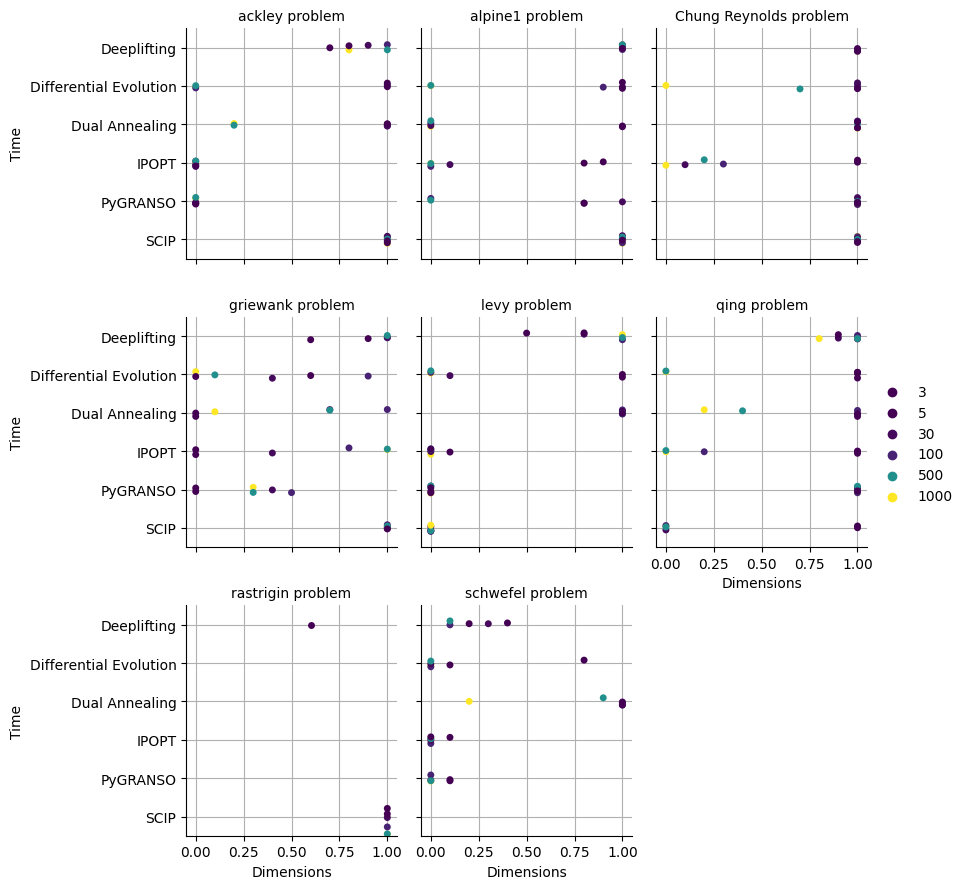

In [15]:
# Create the FacetGrid
g = sns.FacetGrid(
    results_df, col="problem", col_wrap=3, sharex=True, sharey=True, height=3
)

# Map the data to the grid
g.map_dataframe(
    sns.stripplot, x='hits-mean', y='algorithm', hue='dimensions', palette='viridis'
)

# Add legends and other aesthetic improvements
g.add_legend()
g.set_axis_labels("Dimensions", "Time")
g.set_titles(col_template="{col_name} problem")

# Add grids for all axes
for ax in g.axes.flatten():
    ax.grid()

# Use matplotlib instead of seaborn because the jet colors do not exist

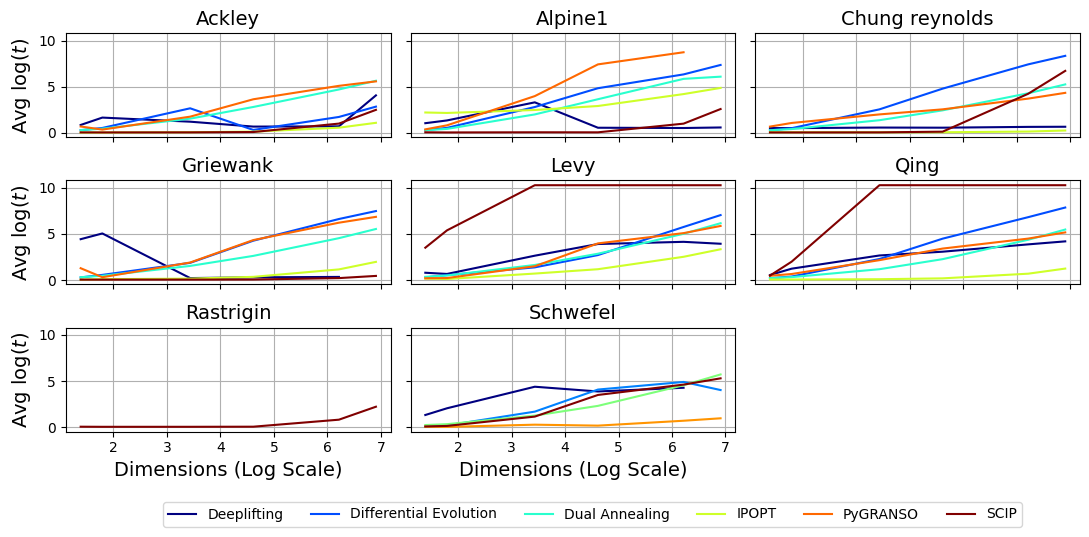

In [16]:
fig, axes = plt.subplots(3, 3, figsize=(11, 5), sharex=True, sharey=True)
axes = axes.flatten()
problems = results_df['problem'].unique().tolist()

lines = []
labels = []
markers = ['o', '*', 'o', '*', 'o', '*', 'o']
for index, problem in enumerate(problems):
    ax = axes[index]
    data = results_df.loc[results_df['problem'] == problem].reset_index(drop=True)
    data = data.pivot_table(
        index='dimensions-log', columns='algorithm', values='time-mean-log'
    )
    line = data.plot(ax=ax, cmap='jet', legend=False)
    ax.set_title(f'{problem.capitalize()}', fontsize=14)
    ax.grid()
    ax.set_xlabel('Dimensions (Log Scale)', fontsize=14)
    ax.set_ylabel('Avg $\log(t)$', fontsize=14)
    # for i, line in enumerate(ax.get_lines()):
    #     line.set_marker(markers[index])

    if index == 0:
        lines, labels = ax.get_legend_handles_labels()

# Turn extra axis off
# axes[7].axis('off')
axes[8].axis('off')

# # Create a single legend for all the plots
fig.legend(lines, labels, bbox_to_anchor=(0.94, 0.0), ncol=6)
fig.tight_layout()
# fig.savefig('/Users/ryandevera/data-science/umn_environments/Deeplifting/paper-images/high-dimension-time-vs-dim.png', bbox_inches='tight', pad_inches=0.01)

In [17]:
(
    results_df.loc[results_df['algorithm'] == 'Deeplifting']
    .pivot_table(
        index='problem', columns=['algorithm', 'dimensions'], values='hits-mean'
    )
    .fillna(0.0)
)

algorithm      Deeplifting                         
dimensions            3    5    30   100  500  1000
problem                                            
Chung Reynolds         1.0  1.0  1.0  1.0  1.0  1.0
ackley                 0.7  0.8  0.9  1.0  1.0  0.8
alpine1                1.0  1.0  1.0  1.0  1.0  1.0
griewank               0.6  0.9  1.0  1.0  1.0  0.0
levy                   0.8  0.5  0.8  1.0  1.0  1.0
qing                   1.0  0.9  0.9  1.0  1.0  0.8
rastrigin              0.6  0.0  0.0  0.0  0.0  0.0
schwefel               0.4  0.2  0.3  0.1  0.1  0.0

In [18]:
(
    results_df.loc[results_df['algorithm'] == 'Differential Evolution']
    .pivot_table(
        index='problem', columns=['algorithm', 'dimensions'], values='hits-mean'
    )
    .fillna(0.0)
)

algorithm      Differential Evolution                         
dimensions                       3    5    30   100  500  1000
problem                                                       
Chung Reynolds                    1.0  1.0  1.0  1.0  0.7  0.0
ackley                            1.0  1.0  1.0  0.0  0.0  0.0
alpine1                           1.0  1.0  1.0  0.9  0.0  0.0
griewank                          0.6  0.0  0.4  0.9  0.1  0.0
levy                              1.0  1.0  0.1  0.0  0.0  0.0
qing                              1.0  1.0  1.0  1.0  0.0  0.0
schwefel                          0.8  0.1  0.0  0.0  0.0  0.0

In [19]:
(
    results_df.loc[results_df['algorithm'] == 'Dual Annealing']
    .pivot_table(
        index='problem', columns=['algorithm', 'dimensions'], values='hits-mean'
    )
    .fillna(0.0)
)

algorithm      Dual Annealing                         
dimensions               3    5    30   100  500  1000
problem                                               
Chung Reynolds            1.0  1.0  1.0  1.0  1.0  1.0
ackley                    1.0  1.0  1.0  1.0  0.2  0.2
alpine1                   1.0  1.0  0.0  0.0  0.0  0.0
griewank                  0.0  0.0  0.7  1.0  0.7  0.1
levy                      1.0  1.0  1.0  1.0  1.0  1.0
qing                      1.0  1.0  1.0  1.0  0.4  0.2
schwefel                  1.0  1.0  1.0  1.0  0.9  0.2

In [20]:
(
    results_df.loc[results_df['algorithm'] == 'IPOPT']
    .pivot_table(
        index='problem', columns=['algorithm', 'dimensions'], values='hits-mean'
    )
    .fillna(0.0)
)

algorithm      IPOPT                         
dimensions      3    5    30   100  500  1000
problem                                      
Chung Reynolds   1.0  1.0  0.1  0.3  0.2  0.0
ackley           0.0  0.0  0.0  0.0  0.0  0.0
alpine1          0.9  0.8  0.1  0.0  0.0  0.0
griewank         0.0  0.0  0.4  0.8  1.0  1.0
levy             0.1  0.0  0.0  0.0  0.0  0.0
qing             1.0  1.0  1.0  0.2  0.0  0.0
schwefel         0.1  0.0  0.0  0.0  0.0  0.0

In [21]:
(
    results_df.loc[results_df['algorithm'] == 'PyGRANSO']
    .pivot_table(
        index='problem', columns=['algorithm', 'dimensions'], values='hits-mean'
    )
    .fillna(0.0)
)

algorithm      PyGRANSO                         
dimensions         3    5    30   100  500  1000
problem                                         
Chung Reynolds      1.0  1.0  1.0  1.0  1.0  1.0
ackley              0.0  0.0  0.0  0.0  0.0  0.0
alpine1             0.8  0.8  1.0  0.0  0.0  0.0
griewank            0.0  0.0  0.4  0.5  0.3  0.3
levy                0.0  0.0  0.0  0.0  0.0  0.0
qing                1.0  1.0  1.0  1.0  1.0  1.0
schwefel            0.1  0.1  0.0  0.0  0.0  0.0

In [22]:
(
    results_df.loc[results_df['algorithm'] == 'SCIP']
    .pivot_table(
        index='problem', columns=['algorithm', 'dimensions'], values='hits-mean'
    )
    .fillna(0.0)
)

algorithm      SCIP                         
dimensions     3    5    30   100  500  1000
problem                                     
Chung Reynolds  1.0  1.0  1.0  1.0  1.0  1.0
ackley          1.0  1.0  1.0  1.0  1.0  1.0
alpine1         1.0  1.0  1.0  1.0  1.0  1.0
griewank        1.0  1.0  1.0  1.0  1.0  1.0
levy            0.0  0.0  0.0  0.0  0.0  0.0
qing            1.0  1.0  0.0  0.0  0.0  0.0
rastrigin       1.0  1.0  1.0  1.0  1.0  1.0

In [23]:
(
    results_df.pivot_table(
        index='algorithm', columns=['problem', 'dimensions'], values='hits-mean'
    )
    .fillna(0.0)
    .mean(axis=1)
    .sort_values(ascending=False)
)

algorithm
Deeplifting               0.710417
SCIP                      0.666667
Dual Annealing            0.637500
Differential Evolution    0.429167
PyGRANSO                  0.339583
IPOPT                     0.229167
dtype: float64

In [24]:
(
    results_df.pivot_table(
        index='algorithm', columns=['problem', 'dimensions'], values='time-mean'
    )
    .fillna(0.0)
    .mean(axis=1)
    .sort_values()
)

algorithm
IPOPT                        6.204318
Deeplifting                 20.017435
Dual Annealing              67.313985
PyGRANSO                   232.722161
Differential Evolution     335.235947
SCIP                      4828.197464
dtype: float64